<a href="https://colab.research.google.com/github/etemtezcan/XNOR-Net-PyTorch/blob/master/quantAwareTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Model

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


class Net(nn.Module):
    def __init__(self, mnist=True):
      
        super(Net, self).__init__()
        if mnist:
          num_channels = 1
        else:
          num_channels = 3
          
        self.conv1 = nn.Conv2d(num_channels, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        if mnist:
          self.fc1 = nn.Linear(4*4*50, 500)
          self.flatten_shape = 4*4*50
        else:
          self.fc1 = nn.Linear(1250, 500)
          self.flatten_shape = 1250

        self.fc2 = nn.Linear(500, 10)
        
      
    def forward(self, x, vis=False, axs=None):
        X = 0
        y = 0

        if vis:
          axs[X,y].set_xlabel('Entry into network, input distribution visualised below: ')
          visualise(x, axs[X,y])

          axs[X,y+1].set_xlabel("Visualising weights of conv 1 layer: ")
          visualise(self.conv1.weight.data, axs[X,y+1])


        x = F.relu(self.conv1(x))

        if vis:
          axs[X,y+2].set_xlabel('Output after conv1 visualised below: ')
          visualise(x,axs[X,y+2])

          axs[X,y+3].set_xlabel("Visualising weights of conv 2 layer: ")
          visualise(self.conv2.weight.data, axs[X,y+3])

        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))

        if vis:
          axs[X,y+4].set_xlabel('Output after conv2 visualised below: ')
          visualise(x,axs[X,y+4])

          axs[X+1,y].set_xlabel("Visualising weights of fc 1 layer: ")
          visualise(self.fc1.weight.data, axs[X+1,y])

        x = F.max_pool2d(x, 2, 2)  
        x = x.view(-1, self.flatten_shape)
        x = F.relu(self.fc1(x))

        if vis:
          axs[X+1,y+1].set_xlabel('Output after fc1 visualised below: ')
          visualise(x,axs[X+1,y+1])

          axs[X+1,y+2].set_xlabel("Visualising weights of fc 2 layer: ")
          visualise(self.fc2.weight.data, axs[X+1,y+2])

        x = self.fc2(x)

        if vis:
          axs[X+1,y+3].set_xlabel('Output after fc2 visualised below: ')
          visualise(x,axs[X+1,y+3])

        return F.log_softmax(x, dim=1)
    

# Training 

In [ ]:

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
   
        if batch_idx % args["log_interval"] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def main(mnist=True):
 
    batch_size = 64
    test_batch_size = 64
    epochs = 10
    lr = 0.01
    momentum = 0.5
    seed = 1
    log_interval = 500
    save_model = False
    no_cuda = False
    
    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    if mnist:
      train_loader = torch.utils.data.DataLoader(
          datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
          batch_size=batch_size, shuffle=True, **kwargs)
      
      test_loader = torch.utils.data.DataLoader(
          datasets.MNIST('../data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
          batch_size=test_batch_size, shuffle=True, **kwargs)
    else:
      transform = transforms.Compose(
          [transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

      trainset = datasets.CIFAR10(root='./dataCifar', train=True,
                                              download=True, transform=transform)
      train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                shuffle=True, num_workers=2)

      testset = datasets.CIFAR10(root='./dataCifar', train=False,
                                            download=True, transform=transform)
      test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                              shuffle=False, num_workers=2)
          
  
    model = Net(mnist=mnist).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    args = {}
    args["log_interval"] = log_interval
    for epoch in range(1, epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)

    if (save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")
    
    return model

model = main()

0it [00:00, ?it/s]

 99%|█████████▉| 9830400/9912422 [00:14<00:00, 823246.52it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]


32768it [00:00, 133961.97it/s]           
0it [00:00, ?it/s]
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



 94%|█████████▍| 1556480/1648877 [00:01<00:00, 930953.40it/s]
1654784it [00:02, 784306.78it/s]                             
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]
8192it [00:00, 50484.33it/s]            

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300039


9920512it [00:29, 823246.52it/s]                             

Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.338142

Test set: Average loss: 0.1018, Accuracy: 9661/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.146005
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.032796

Test set: Average loss: 0.0613, Accuracy: 9828/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.053123
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.029650

Test set: Average loss: 0.0563, Accuracy: 9810/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.019305
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.015217

Test set: Average loss: 0.0407, Accuracy: 9866/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.010525
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.042274

Test set: Average loss: 0.0379, Accuracy: 9869/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.127333
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.013009

Test set: Average loss: 0.0340, Accuracy: 9892/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.029281
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.013817

Test set: Ave

# Quantisation of Network

## Quantisation Functions

In [ ]:
from collections import namedtuple
import torch
import torch.nn as nn

QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])

def calcScaleZeroPoint(min_val, max_val,num_bits=8):
  # Calc Scale and zero point of next 
  qmin = 0.
  qmax = 2.**num_bits - 1.

  scale = (max_val - min_val) / (qmax - qmin)

  initial_zero_point = qmin - min_val / scale
  
  zero_point = 0
  if initial_zero_point < qmin:
      zero_point = qmin
  elif initial_zero_point > qmax:
      zero_point = qmax
  else:
      zero_point = initial_zero_point

  zero_point = int(zero_point)

  return scale, zero_point

def calcScaleZeroPointSym(min_val, max_val,num_bits=8):
  
  # Calc Scale 
  max_val = max(abs(min_val), abs(max_val))
  qmin = 0.
  qmax = 2.**(num_bits-1) - 1.

  scale = max_val / qmax

  return scale, 0

def quantize_tensor(x, num_bits=8, min_val=None, max_val=None):
    
    if not min_val and not max_val: 
      min_val, max_val = x.min(), x.max()

    qmin = 0.
    qmax = 2.**num_bits - 1.

    scale, zero_point = calcScaleZeroPoint(min_val, max_val, num_bits)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    q_x = q_x.round().byte()
    
    return QTensor(tensor=q_x, scale=scale, zero_point=zero_point)

def dequantize_tensor(q_x):
    return q_x.scale * (q_x.tensor.float() - q_x.zero_point)

def quantize_tensor_sym(x, num_bits=8, min_val=None, max_val=None):
    
    if not min_val and not max_val: 
      min_val, max_val = x.min(), x.max()

    max_val = max(abs(min_val), abs(max_val))
    qmin = 0.
    qmax = 2.**(num_bits-1) - 1.

    scale = max_val / qmax   

    q_x = x/scale

    q_x.clamp_(-qmax, qmax).round_()
    q_x = q_x.round()
    return QTensor(tensor=q_x, scale=scale, zero_point=0)

def dequantize_tensor_sym(q_x):
    return q_x.scale * (q_x.tensor.float())

## Rework Forward pass of Linear and Conv Layers to support Quantisation

In [ ]:
def quantizeLayer(x, layer, stat, scale_x, zp_x, vis=False, axs=None, X=None, y=None, sym=False, num_bits=8):
  # for both conv and linear layers

  # cache old values
  W = layer.weight.data
  B = layer.bias.data

  # WEIGHTS SIMULATED QUANTISED

  # quantise weights, activations are already quantised
  if sym:
    w = quantize_tensor_sym(layer.weight.data,num_bits=num_bits) 
    b = quantize_tensor_sym(layer.bias.data,num_bits=num_bits)
  else:
    w = quantize_tensor(layer.weight.data, num_bits=num_bits) 
    b = quantize_tensor(layer.bias.data, num_bits=num_bits)

  layer.weight.data = w.tensor.float()
  layer.bias.data = b.tensor.float()

  ## END WEIGHTS QUANTISED SIMULATION


  if vis:
    axs[X,y].set_xlabel("Visualising weights of layer: ")
    visualise(layer.weight.data, axs[X,y])

  # QUANTISED OP, USES SCALE AND ZERO POINT TO DO LAYER FORWARD PASS. (How does backprop change here ?)
  # This is Quantisation Arithmetic
  scale_w = w.scale
  zp_w = w.zero_point
  scale_b = b.scale
  zp_b = b.zero_point
  
  if sym:
    scale_next, zero_point_next = calcScaleZeroPointSym(min_val=stat['min'], max_val=stat['max'])
  else:
    scale_next, zero_point_next = calcScaleZeroPoint(min_val=stat['min'], max_val=stat['max'])

  # Preparing input by saturating range to num_bits range.
  if sym:
    X = x.float()
    layer.weight.data = ((scale_x * scale_w) / scale_next)*(layer.weight.data)
    layer.bias.data = (scale_b/scale_next)*(layer.bias.data)
  else:
    X = x.float() - zp_x
    layer.weight.data = ((scale_x * scale_w) / scale_next)*(layer.weight.data - zp_w)
    layer.bias.data = (scale_b/scale_next)*(layer.bias.data + zp_b)

  # All int computation
  if sym:  
    x = (layer(X)) 
  else:
    x = (layer(X)) + zero_point_next 
  
  # cast to int
  x.round_()

  # Perform relu too
  x = F.leaky_relu(x)

  # Reset weights for next forward pass
  layer.weight.data = W
  layer.bias.data = B
  
  return x, scale_next, zero_point_next


## Get Stats for Quantising Activations of Network.

This is done by running the network with around 1000 examples and getting the average min and max activation values before and after each layer.

In [ ]:
# Get Min and max of x tensor, and stores it
def updateStats(x, stats, key):
  max_val, _ = torch.max(x, dim=1)
  min_val, _ = torch.min(x, dim=1)

  # add ema calculation

  if key not in stats:
    stats[key] = {"max": max_val.sum(), "min": min_val.sum(), "total": 1}
  else:
    stats[key]['max'] += max_val.sum().item()
    stats[key]['min'] += min_val.sum().item()
    stats[key]['total'] += 1
  
  weighting = 2.0 / (stats[key]['total']) + 1

  if 'ema_min' in stats[key]:
    stats[key]['ema_min'] = weighting*(min_val.mean().item()) + (1- weighting) * stats[key]['ema_min']
  else:
    stats[key]['ema_min'] = weighting*(min_val.mean().item())

  if 'ema_max' in stats[key]:
    stats[key]['ema_max'] = weighting*(max_val.mean().item()) + (1- weighting) * stats[key]['ema_max']
  else: 
    stats[key]['ema_max'] = weighting*(max_val.mean().item())

  stats[key]['min_val'] = stats[key]['min']/ stats[key]['total']
  stats[key]['max_val'] = stats[key]['max']/ stats[key]['total']
  
  return stats

# Reworked Forward Pass to access activation Stats through updateStats function
def gatherActivationStats(model, x, stats):

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv1')
  
  x = F.relu(model.conv1(x))

  x = F.max_pool2d(x, 2, 2)
  
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv2')
  
  x = F.relu(model.conv2(x))

  x = F.max_pool2d(x, 2, 2)

  x = x.view(-1, 4*4*50)
  
  stats = updateStats(x, stats, 'fc1')

  x = F.relu(model.fc1(x))
  
  stats = updateStats(x, stats, 'fc2')

  x = model.fc2(x)

  return stats

# Entry function to get stats of all functions.
def gatherStats(model, test_loader):
    device = 'cuda'
    
    model.eval()
    test_loss = 0
    correct = 0
    stats = {}
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            stats = gatherActivationStats(model, data, stats)
    
    final_stats = {}
    for key, value in stats.items():
      final_stats[key] = { "max" : value["max"] / value["total"], "min" : value["min"] / value["total"], "ema_min": value["ema_min"], "ema_max": value["ema_max"] }
    return final_stats

## Forward Pass for Quantised Inference

In [ ]:
def quantForward(model, x, stats, vis=False, axs=None, sym=False, num_bits=8):
  X = 0
  y = 0
  # Quantise before inputting into incoming layers
  if sym:
    x = quantize_tensor_sym(x, min_val=stats['conv1']['min'], max_val=stats['conv1']['max'], num_bits=num_bits)
  else:
    x = quantize_tensor(x, min_val=stats['conv1']['min'], max_val=stats['conv1']['max'], num_bits=num_bits)

  if vis:
    axs[X,y].set_xlabel('Entry into network, input distribution visualised below: ')
    visualise(x.tensor, axs[X,y])
  
  x, scale_next, zero_point_next = quantizeLayer(x.tensor, model.conv1, stats['conv2'], x.scale, x.zero_point, vis, axs, X=X, y=y+1, sym=sym, num_bits=num_bits)

  x = F.max_pool2d(x, 2, 2)
  
  if vis:
    axs[X,y+2].set_xlabel('Output after conv1 visualised below: ')
    visualise(x,axs[X,y+2])

  x, scale_next, zero_point_next = quantizeLayer(x, model.conv2, stats['fc1'], scale_next, zero_point_next, vis, axs, X=X, y=y+3, sym=sym, num_bits=num_bits)

  x = F.max_pool2d(x, 2, 2)

  if vis:
    axs[X,y+4].set_xlabel('Output after conv2 visualised below: ')
    visualise(x,axs[X,y+4])

  x = x.view(-1, 4*4*50)

  x, scale_next, zero_point_next = quantizeLayer(x, model.fc1, stats['fc2'], scale_next, zero_point_next, vis, axs, X=X+1, y=0, sym=sym, num_bits=num_bits)

  if vis:
    axs[X+1,1].set_xlabel('Output after fc1 visualised below: ')
    visualise(x,axs[X+1,1])
  
  # Back to dequant for final layer
  if sym:
    x = dequantize_tensor_sym(QTensor(tensor=x, scale=scale_next, zero_point=zero_point_next))
  else:
    x = dequantize_tensor(QTensor(tensor=x, scale=scale_next, zero_point=zero_point_next))

  if vis:
    axs[X+1,2].set_xlabel('Output after fc1 but dequantised visualised below: ')
    visualise(x,axs[X+1,2])

  x = model.fc2(x)

  if vis:
    axs[X+1,3].set_xlabel('Unquantised Weights of fc2 layer')
    visualise(model.fc2.weight.data,axs[X+1,3])

    axs[X+1,2].set_xlabel('Output after fc2 but dequantised visualised below: ')
    visualise(x,axs[X+1,4])

  return F.log_softmax(x, dim=1)

# Testing Function for Quantisation

In [ ]:
def testQuant(model, test_loader, quant=False, stats=None, sym=False, num_bits=8):
    device = 'cuda'
    
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if quant:
              output = quantForward(model, data, stats, sym=sym, num_bits=num_bits)
            else:
              output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Get Accuracy of Non Quantised Model

In [ ]:
import copy
q_model = copy.deepcopy(model)

In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True, **kwargs)

In [ ]:
testQuant(q_model, test_loader, quant=False)


Test set: Average loss: 0.0315, Accuracy: 9897/10000 (99%)



# Gather Stats of Activations

In [ ]:
stats = gatherStats(q_model, test_loader)
print(stats)

{'conv1': {'max': tensor(179.6297, device='cuda:0'), 'min': tensor(-27.0200, device='cuda:0'), 'ema_min': -0.4242129623889923, 'ema_max': 2.8206961097475127}, 'conv2': {'max': tensor(567.2593, device='cuda:0'), 'min': tensor(0., device='cuda:0'), 'ema_min': 0.0, 'ema_max': 8.852602079032536}, 'fc1': {'max': tensor(999.8044, device='cuda:0'), 'min': tensor(0., device='cuda:0'), 'ema_min': 0.0, 'ema_max': 16.11473465414505}, 'fc2': {'max': tensor(541.5958, device='cuda:0'), 'min': tensor(0., device='cuda:0'), 'ema_min': 0.0, 'ema_max': 8.053078164634293}}


# Test Quantised Inference Of Model

In [ ]:
testQuant(q_model, test_loader, quant=True, stats=stats, sym=False, num_bits=6)


Test set: Average loss: 0.1020, Accuracy: 9679/10000 (97%)



In [ ]:
testQuant(q_model, test_loader, quant=True, stats=stats, sym=True, num_bits=8)


Test set: Average loss: 0.0807, Accuracy: 9738/10000 (97%)



In [ ]:
testQuant(q_model, test_loader, quant=True, stats=stats, sym=True, num_bits=4)


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)



See, when we go down to 4 bits, the accuracy craters !

# Visualise Weights and Activations

In [ ]:
def visualise(x, axs):
  x = x.view(-1).cpu().numpy()
  axs.hist(x) 

## Visualise Quantised Model

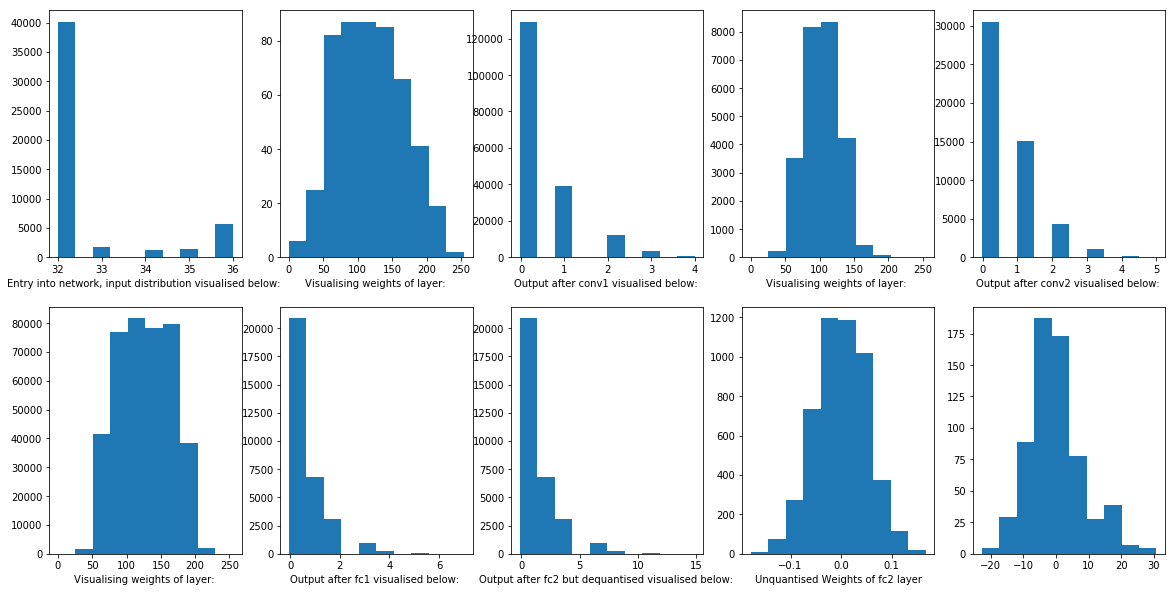

In [ ]:
import matplotlib.pyplot as plt
# run through one example and plot weights and activations quantised in real time
device = 'cuda'
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = quantForward(q_model, data, stats, vis=True, axs=axs, sym=False)
        break
plt.show()

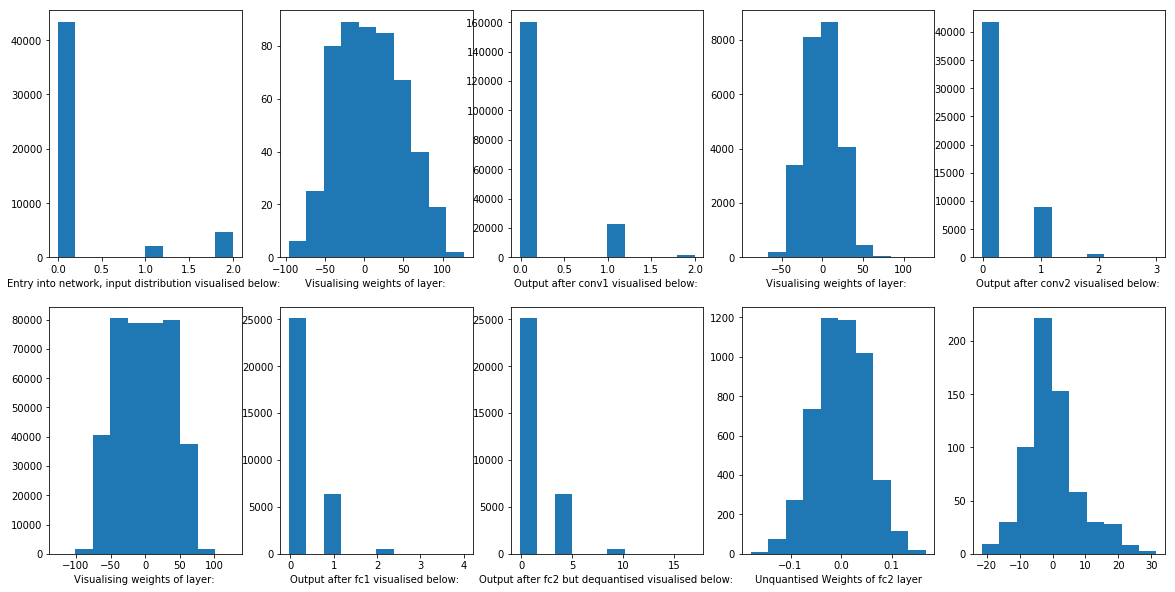

In [ ]:
import matplotlib.pyplot as plt
# run through one example and plot weights and activations quantised in real time
device = 'cuda'
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = quantForward(q_model, data, stats, vis=True, axs=axs, sym=True)
        break
plt.show()

## Non Quantised Network weights and activations

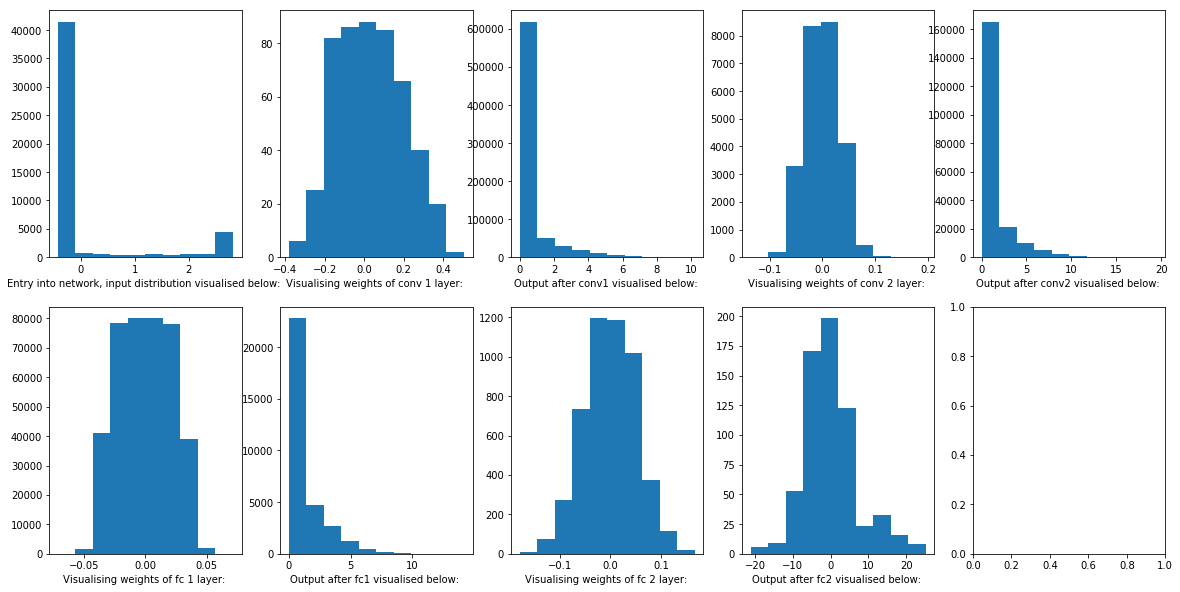

In [ ]:
# run through one example and plot weights and activations quantised in real time
device = 'cuda'
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data, vis=True, axs=axs)
        break
plt.show()

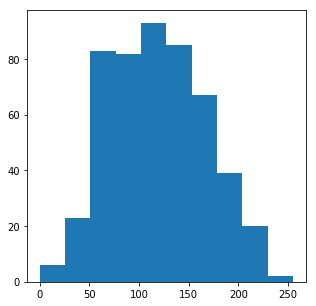

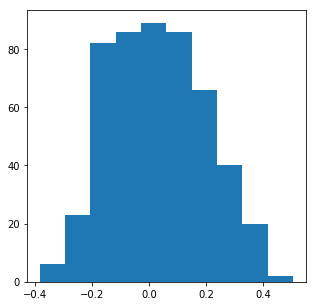

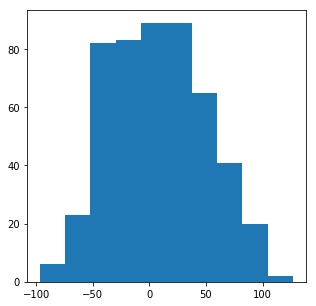

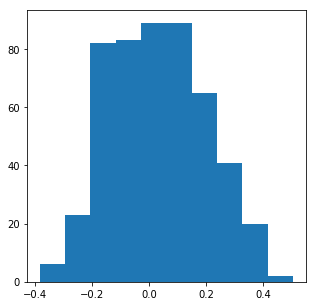

In [ ]:
quantisedConv1 = quantize_tensor(model.conv1.weight.data)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.hist(quantisedConv1.tensor.cpu().view(-1).numpy())

plt.show()

quantisedConv1 = model.conv1.weight.data
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.hist(quantisedConv1.cpu().view(-1).numpy())

plt.show()

quantisedConv1 = quantize_tensor_sym(model.conv1.weight.data)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.hist(quantisedConv1.tensor.cpu().view(-1).numpy())

plt.show()

unquantisedConv1 = dequantize_tensor_sym(quantisedConv1)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.hist(unquantisedConv1.cpu().view(-1).numpy())

plt.show()

## TA DA !!

We have quantised our net to mostly 8 bit arithmetic with almost zero accuracy loss ! Pretty good day's work, I'll say :D

# Quantisation Aware Training

In [ ]:
import torch

class FakeQuantOp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, num_bits=8, min_val=None, max_val=None):
        x = quantize_tensor(x,num_bits=num_bits, min_val=min_val, max_val=max_val)
        x = dequantize_tensor(x)
        return x

    @staticmethod
    def backward(ctx, grad_output):
        # straight through estimator
        return grad_output, None, None, None

In [ ]:
x = torch.tensor([1,2,3,4]).float()
print(FakeQuantOp.apply(x))

tensor([1., 2., 3., 3.])


## Quantization Aware Training Forward Pass

In [ ]:
def quantAwareTrainingForward(model, x, stats, vis=False, axs=None, sym=False, num_bits=8, act_quant=False):
  
  conv1weight = model.conv1.weight.data
  model.conv1.weight.data = FakeQuantOp.apply(model.conv1.weight.data, num_bits)
  x = F.relu(model.conv1(x))

  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv1')

  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['conv1']['ema_min'], stats['conv1']['ema_max'])

  x = F.max_pool2d(x, 2, 2)

  conv2weight = model.conv2.weight.data
  model.conv2.weight.data = FakeQuantOp.apply(model.conv2.weight.data, num_bits)
  x = F.relu(model.conv2(x))

  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv2')
    
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['conv2']['ema_min'], stats['conv2']['ema_max'])


  x = F.max_pool2d(x, 2, 2)

  x = x.view(-1, 4*4*50)

  fc1weight = model.fc1.weight.data
  model.fc1.weight.data = FakeQuantOp.apply(model.fc1.weight.data, num_bits)
  x = F.relu(model.fc1(x))

  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'fc1')

  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['fc1']['ema_min'], stats['fc1']['ema_max'])

  x = model.fc2(x)
  
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'fc2')

  return F.log_softmax(x, dim=1), conv1weight, conv2weight, fc1weight, stats

# Train using Quantization Aware Training

In [ ]:
def trainQuantAware(args, model, device, train_loader, optimizer, epoch, stats, act_quant=False, num_bits=4):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, conv1weight, conv2weight, fc1weight, stats = quantAwareTrainingForward(model, data, stats, num_bits=num_bits, act_quant=act_quant)

        model.conv1.weight.data = conv1weight
        model.conv2.weight.data = conv2weight
        model.fc1.weight.data = fc1weight

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % args["log_interval"] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return stats

def testQuantAware(args, model, device, test_loader, stats, act_quant, num_bits=4):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, conv1weight, conv2weight, fc1weight, _ = quantAwareTrainingForward(model, data, stats, num_bits=num_bits, act_quant=act_quant)
            
            model.conv1.weight.data = conv1weight
            model.conv2.weight.data = conv2weight
            model.fc1.weight.data = fc1weight

            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def mainQuantAware(mnist=True):
 
    batch_size = 64
    test_batch_size = 64
    epochs = 10
    lr = 0.01
    momentum = 0.5
    seed = 1
    log_interval = 500
    save_model = False
    no_cuda = False
    
    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    if mnist:
      train_loader = torch.utils.data.DataLoader(
          datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
          batch_size=batch_size, shuffle=True, **kwargs)
      
      test_loader = torch.utils.data.DataLoader(
          datasets.MNIST('../data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
          batch_size=test_batch_size, shuffle=True, **kwargs)
    else:
      transform = transforms.Compose(
          [transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

      trainset = datasets.CIFAR10(root='./dataCifar', train=True,
                                              download=True, transform=transform)
      train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                shuffle=True, num_workers=2)

      testset = datasets.CIFAR10(root='./dataCifar', train=False,
                                            download=True, transform=transform)
      test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                              shuffle=False, num_workers=2)
          
  
    model = Net(mnist=mnist).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    args = {}
    args["log_interval"] = log_interval
    epochs = 10
    num_bits=4
    stats = {}
    for epoch in range(1, epochs + 1):
        if epoch > 5:
          act_quant = True 
        else:
          act_quant = False

        stats = trainQuantAware(args, model, device, train_loader, optimizer, epoch, stats, act_quant, num_bits=num_bits)
        testQuantAware(args, model, device, test_loader, stats, act_quant, num_bits=num_bits)

    if (save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")

    return model, stats

model, old_stats = mainQuantAware()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301193
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.342981

Test set: Average loss: 0.1025, Accuracy: 9667/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.141286
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.032263

Test set: Average loss: 0.0631, Accuracy: 9815/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.058591
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.028846

Test set: Average loss: 0.0546, Accuracy: 9817/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.017846
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.013403

Test set: Average loss: 0.0406, Accuracy: 9864/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.009576
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.041015

Test set: Average loss: 0.0389, Accuracy: 9862/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.125013
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.012849

Test set: Average loss: 0.0342, Accuracy: 9884/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.024167
Train Epoch: 7 [320

# Test Quantization Aware Training

In [ ]:
def testQuantAware(model, test_loader, stats=None, sym=False, num_bits=4):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, conv1weight, conv2weight, fc1weight, _ = quantAwareTrainingForward(model, data, stats, num_bits=num_bits, act_quant=True, sym=False)
            
            model.conv1.weight.data = conv1weight
            model.conv2.weight.data = conv2weight
            model.fc1.weight.data = fc1weight

            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Load Dataset

In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True, **kwargs)

## Test Quant Aware 

In [ ]:
print(old_stats)

{'conv1': {'max': tensor(5744082.5000, device='cuda:0'), 'min': tensor(0., device='cuda:0'), 'total': 10950, 'ema_min': 0.0, 'ema_max': 9.274255717045133, 'min_val': tensor(0., device='cuda:0'), 'max_val': tensor(524.5738, device='cuda:0')}, 'conv2': {'max': tensor(9586757., device='cuda:0'), 'min': tensor(0., device='cuda:0'), 'total': 10950, 'ema_min': 0.0, 'ema_max': 15.702470554098719, 'min_val': tensor(0., device='cuda:0'), 'max_val': tensor(875.5029, device='cuda:0')}, 'fc1': {'max': tensor(5093591.5000, device='cuda:0'), 'min': tensor(0., device='cuda:0'), 'total': 10950, 'ema_min': 0.0, 'ema_max': 9.155645161310805, 'min_val': tensor(0., device='cuda:0'), 'max_val': tensor(465.1682, device='cuda:0')}, 'fc2': {'max': tensor(9082535., device='cuda:0'), 'min': tensor(-5911903.5000, device='cuda:0'), 'total': 10950, 'ema_min': -10.148727026162197, 'ema_max': 16.657566443834714, 'min_val': tensor(-539.8999, device='cuda:0'), 'max_val': tensor(829.4553, device='cuda:0')}}


In [ ]:
import copy
q_model = copy.deepcopy(model)

In [ ]:
testQuantAware(q_model, test_loader, stats=old_stats, sym=False, num_bits=4)


Test set: Average loss: 0.0325, Accuracy: 9892/10000 (99%)



## Voila

We're back to test accuracy.

# Vis 2 bit Model Weights

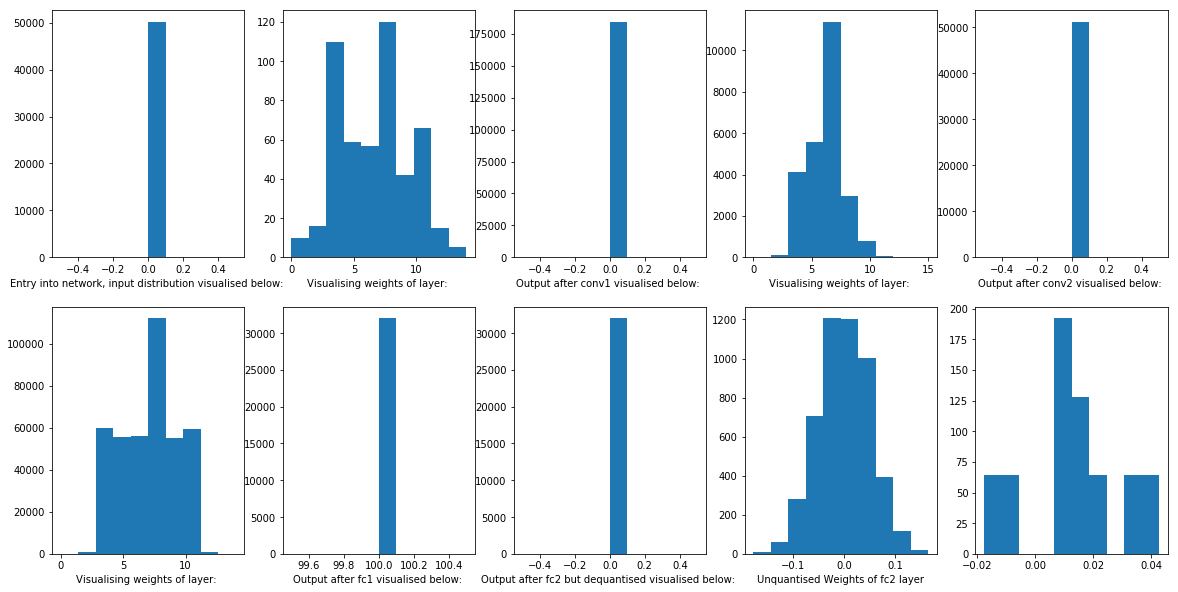

In [ ]:
import matplotlib.pyplot as plt
# run through one example and plot weights and activations quantised in real time
device = 'cuda'
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        quantForward(q_model, data, old_stats, vis=True, axs=axs, sym=False, num_bits=4)
#         output = quantAwareTrainingForward(q_model, data, old_stats, vis=True, axs=axs, sym=False, num_bits=2, act_quant=True)
        break
plt.show()